# inverse operation of polygonize

In [17]:
%pylab inline
import geopandas as gpd
import logging as log
import fiona, shapely
from shapely.geometry import LineString, MultiPolygon
from shapely.ops import polygonize
from slib import *
import geopandas
log.getLogger().setLevel(log.DEBUG)

mpl.rcParams['figure.figsize'] = [12, 12.0]


# vector layer with contacts
contacts = "../input_data/contacts" # contacts also contain the boundind box.


# here are a vector layer with points. each points need to have a field with an unique id for each geological unit
unit_id = "../input_data/unit_id"
unit_uuid_name = "Unit_Code" # the name of the field to use to populate the map.
layer_name = "Apl_Strat_full"
layer_name = "cleaned"

# output data - geopackage
inputfname = "/data/SciDataHub/projects/map_validation/PM-MOO-MS-SPAApollo_01.gpkg"
inputfname = "/home/luca/vertices_snapped.gpkg"

dist = 1.0 # extend of 1 meters all the extreme segments of contacts - needed to ensure proper intersections


Populating the interactive namespace from numpy and matplotlib


/run/media/luca/data/virtual_envs/fiona/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['Polygon', 'ma', 'log']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [18]:
startmap = geopandas.GeoDataFrame.from_file(inputfname,layer=layer_name)


# this below should become a check: presence of null geometries

In [19]:
if np.any(startmap.geometry.values == None):
    log.info("dropping null entries")
    startmap = startmap[startmap.geometry.values != None] # remove null geometries 

# plot the input dataset - the geological map

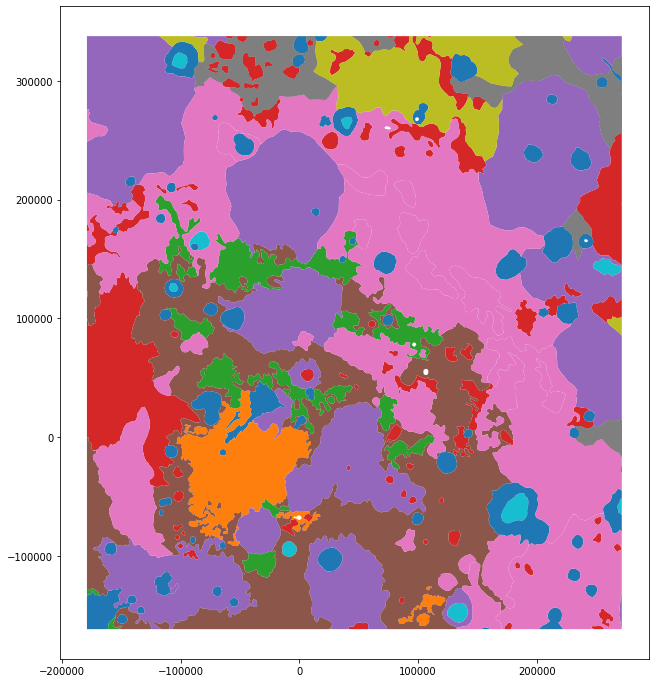

In [20]:
startmap.plot( ax=gca(), column=unit_uuid_name)

# first task: generate the outline of mapped area. 
strategies might be variable, here we try with an union

In [21]:
# from shapely.ops import unary_union
# allpols = list(tg.geoms for tg in startmap.geometry if tg is not None and tg.is_valid)
# union = unary_union(allpols) # in this case is simple, but might as well be more complex, with holes inside and on the boundary. to be tested on more complex maps



# this should be another check. Validity of entities.

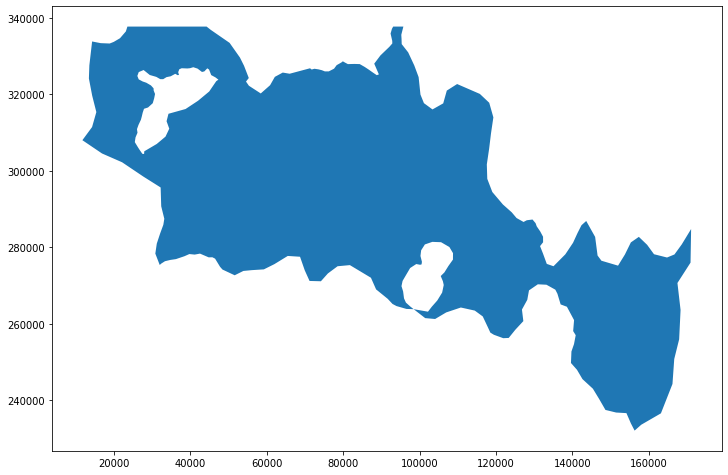

In [22]:
is_valid = [p.is_valid for p in startmap.geometry]
invalid = startmap[~np.array(is_valid)] # extract invalid portions
invalid.plot() # plot the entities that result to be invalid - they are invalid because self-intersecting mostly

In [23]:
startmap.geometry = startmap.buffer(0)
np.sum([p.is_valid for p in startmap.geometry]) == len(startmap) # this must be true, or else not all features were corrected

True

<Figure size 864x864 with 0 Axes>

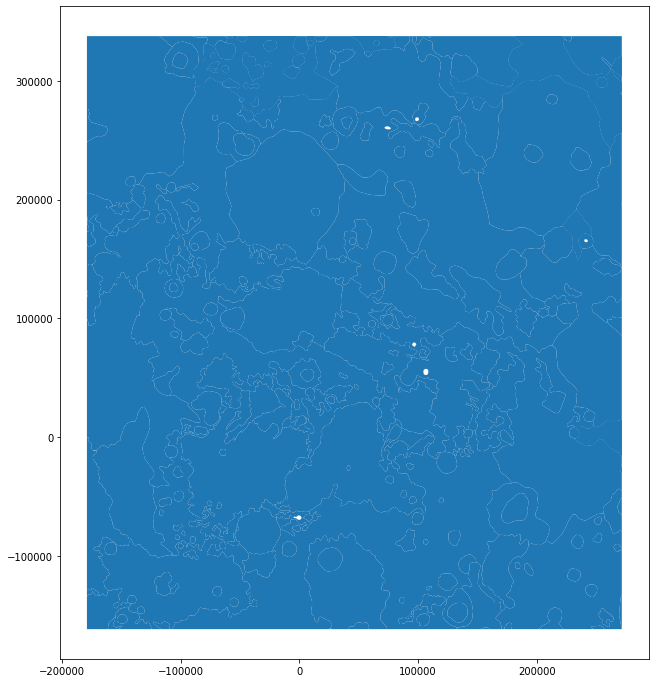

In [24]:
figure()
startmap.plot()

In [25]:
ma = startmap

ma = ma.drop_duplicates("geometry") # remove any geometry that is duplicated. 
#we should also check that any removed geometry has the same items in the table or raise an error. 
#for this we can use duplicated!
print(f"removed {len(startmap) - len(ma)} duplicates ")

removed 5 duplicates 


In [26]:
from ipypb import track

In [27]:
from shapely.strtree import STRtree
t = STRtree(ma.geometry)

In [28]:
ints = []
for g in track(ma.geometry):    
    pot_int = t.query(g)
    pot_int.remove (g)
    
    for pot in pot_int:
        if g.intersects(pot):
            tosave = g.intersection(pot)
            ints.append(tosave)
            
        if g.equals(pot):
            print("equal")
        


 [████████████████████████████████████████████████████████████] 248/248 [00:02<00:00, 0.01s/it]

In [29]:
import geopandas as gpd
df = gpd.GeoDataFrame()
df.geometry = ints


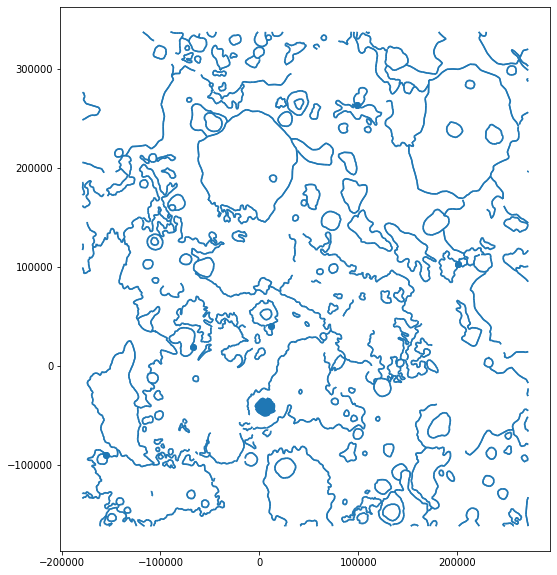

In [30]:
figure(figsize=(10,10))
df.plot(ax=gca())

In [31]:
allg = []

for g in df.geometry:
    allg+= explode(g)
    
p,l,pol=filter_by_type(allg)

In [32]:
g = gpd.GeoDataFrame(crs=ma.crs)
g.geometry = pol
g.to_file("/home/luca/intersections.gpkg",driver="GPKG", layer="polygons")


g = gpd.GeoDataFrame(crs=ma.crs)
g.geometry = l
g.to_file("/home/luca/intersections.gpkg",driver="GPKG", layer="lines")

g = gpd.GeoDataFrame(crs=ma.crs)
g.geometry = p
g.to_file("/home/luca/intersections.gpkg",driver="GPKG", layer="points")